# Technical Assessment

## Overview

- **Author:**
    - Alex Sandro Alves de Araujo (alex.fate2000@gmail.com).
- **Programming Language:**
    - Python 3.
- **Part 1 - Preprocessing and Understanding Raw Data:**
    - Categorical features were transformed into **category** data types represented by integers.
    - We could see that prices labeled with **From** are equal or greater than values labeled with **To** in purchase features.
    - It is likely that each row of the original data table refers to the most expensive sku on that ordering. When **From** and **To** purchase features are equal, and then all **min**, **max**, and **avg** prices are equal too, and this might mean that there was only one type of sku in the ordering, which could be a single or multiple units of that sku.**
    - What are the macro categories responsible for 80% of the billing over the entire dataset period? Answer: considering revenues as the multiplication of two features, **avgPurchaseValueTo** times **amount**, then 4 categories are responsible for 80% of the billing: C22, C9, C7, and C1.
    - Train data is from 2018 January to 2019 December (**95.86%**), and test set is January 2020 (**4.14%**)
- **Part 2 - Univariate Time Series Forecasting:**
    - We resampled revenue time series to **daily** time step. 
    - Without feature engineering at this step. We choose a **XGBoost** regressor as our forecasting model because its results were better than a SARIMA model used previously (SARIMA results not shown in this notebook).  
    - The model tries to forecast the revenue in a given day based on revenues within 30 days earlier (**window_size=30**).
    - Train data: January 2018 - November 2019; Validation data: December 2019.
    - Search for the best hyperparameter set among **2625** candidates, varying the number of boosting rounds (**n_estimators**), tree max depth (**max_depth**), boosting learning rate (**learning_rate**), L1 regularization term on weights (**reg_alpha**), and L2 regularization term on weights (**reg_lambda**).
    - Results for 2019 December:
        - MSE: **2.16e14**
        - RMSE: **1.47e07**
        - MAPE: **42.31%**
        - WMAPE: **23.39%**
    - Results for 2020 January:
        - MSE: **1.16e14**
        - RMSE: **1.08e07**
        - MAPE: **25.01%**
        - WMAPE: **22.71%**        
- **Part 3 - Multivariate Time Series Forecasting:** 
    - We resampled revenue time series to **daily** time step.
    - Not so much feature engineering here, just few purchase information only (**avgRevenueToDailyCount**, **avgRevenueToDailyMin**, **minPurchaseValueFromDailySum**, **minPurchaseValueFromDailyMax**, **skuLengthDailyMean**, **skuWidthDailyMean**, **skuHeightDailyMean**, **amountDailyMax**). Again, We choose a **XGBoost** regressor as our forecasting model.
    - The model tries to forecast the revenue in a given day based on sliding windows of 30 days (**window_size=30**) for all used features. This results in higher dimensionality (**240** features).
    - Apply PCA to reduce dimensionality.
    - Train data: January 2018 - November 2019; Validation data: December 2019.
    - Search for the best hyperparameter set among **324** candidates, varying the number of principal components in PCA (**n_components**), boosting rounds (**n_estimators**), tree max depth (**max_depth**), boosting learning rate (**learning_rate**), L1 regularization term on weights (**reg_alpha**), and L2 regularization term on weights (**reg_lambda**).
    - Results for 2019 December:
        - MSE: **1.03e14**
        - RMSE: **1.01e07**
        - MAPE: **14.17%**
        - WMAPE: **11.72%**
    - Results for 2020 January:
        - MSE: **1.47e14**
        - RMSE: **1.21e07**
        - MAPE: **28.73%**
        - WMAPE: **26.00%**       
- **Conclusions:**
    - Our multivariate forecasting does not show any sensible improvement regarding results from univariate modeling. Maybe this can be due to the insufficient feature engineering and the increased dimension of this formulation without the necessary data quantity.
    - Future work suggestions: more feature engineering and Boosting with Bayesian hyper parameter search.

## Initial Setup

In [1]:
%%time

# Load packages.
import os
import sys
import warnings
import itertools

import numpy as np 
import pandas as pd
import matplotlib as mpl
import sklearn as skl
import tensorflow as tf

from matplotlib import pyplot as plt
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.decomposition import PCA
from sklearn.metrics import (make_scorer, 
                             mean_squared_error,  
                             mean_absolute_error,
                             r2_score)

warnings.filterwarnings("ignore")

%matplotlib inline

CPU times: user 3.06 s, sys: 628 ms, total: 3.69 s
Wall time: 4.92 s


**Versions for python packages.**

In [2]:
print(">>> Python:", sys.version)
print("* Numpy:", np.__version__)
print("* Pandas:", pd.__version__)
print("* Matplotlib:", mpl.__version__)
print("* Scikit - Learn:", skl.__version__)
print("* Tensorflow:", tf.__version__)

>>> Python: 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
[GCC 9.3.0]
* Numpy: 1.19.1
* Pandas: 1.1.1
* Matplotlib: 3.3.1
* Scikit - Learn: 0.23.2
* Tensorflow: 2.2.0


**Information on the machine used for this task.**

In [3]:
print("\n>>> Computer:")
!echo "* Hostname: ${HOSTNAME}"
!echo "* User: ${USER}"
!echo "* Directory: $(pwd)"
!echo "* Date: $(date)"
!echo "* CPU architecture:"
!echo "$(lscpu)"
!echo "RAM memory:"
!echo "$(free -gt)"


>>> Computer:
* Hostname: n007
* User: sandroal
* Directory: /work/sandroal/notebooks/data_science/coteminas
* Date: Tue Mar 30 21:47:27 BRT 2021
* CPU architecture:
Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                40
On-line CPU(s) list:   0-39
Thread(s) per core:    2
Core(s) per socket:    10
Socket(s):             2
NUMA node(s):          2
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 62
Stepping:              4
CPU MHz:               1200.000
BogoMIPS:              4988.39
Virtualization:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              25600K
NUMA node0 CPU(s):     0-9,20-29
NUMA node1 CPU(s):     10-19,30-39
RAM memory:
             total       used       free     shared    buffers     cached
Mem:            62         32         30          0          0         31
-/+ buffers/cache:          1 

In [4]:
# Final results.
save_fig = True

# Put images here.
FIG_FOLDER = "/work/sandroal/notebooks/data_science/coteminas/"

**Ancillary tools. Functions that I wrote for time series data generating and other functions given in the assessment.**

In [5]:
###############################################################################
# Univariate time series machine learning.
def univariate_auto_features(
        time_series,
        window_size,
    ):
    """
    Create sequence windows of data from a single time series.

    Parameters
    ----------
    time_series : np.array
        Target univariate time series.
    window_size : int       
        Maximum shift to be used in features.
 
    Returns
    -------
    X : 2D np.ndarray
        The dataset with windowed values of the target.
    y : np.array 
        Target values one step ahead.
    """  

    # Size of the time series.
    n = time_series.shape[0]    
    
    # Reshape data in order to be used in data generator.
    data = time_series.reshape((-1, 1))
    targets = data.copy()
    
    # Utility class for generating batches of temporal data.
    dg = tf.keras.preprocessing.sequence.TimeseriesGenerator(
        data=data,
        targets=targets,
        length=int(window_size),
        batch_size=n
    )
    
    # Just one batch of data. The data generator instance has length one.
    Xgen, ygen = dg[0]
    
    # Reshape data in order to fit sklearn's Classes.
    # X: Instances (rows) and features (columns).
    X = Xgen.reshape((Xgen.shape[0], -1))
    y = ygen.reshape((ygen.shape[0], ))
    
    return X, y

###############################################################################
# Multivariate time series machine learning.
def make_sequences(
        features, 
        target, 
        window_size
    ):
    """
    Create sequence windows of data from temporal features and target.

    Parameters
    ----------
    features : 2D np.array
        Temporal data matrix.
    target : np.array    
        Target univariate time series.
    window_size : int       
        Maximum shift to be used in features.
 
    Returns
    -------
    X : 2D np.ndarray
        The dataset with windowed values of the features.
    y : np.array 
        Target values one step ahead.
    """
    # Size of the time series.
    n = features.shape[0]  
    
    # Utility class for generating batches of temporal data.
    dg = tf.keras.preprocessing.sequence.TimeseriesGenerator(
        data=features,
        targets=target,
        length=int(window_size),
        batch_size=n
    )
    
    # Just one batch of data. The data generator instance has length one.
    Xgen, ygen = dg[0]
    
    # Reshape data in order to fit sklearn's Classes.
    # X: Instances (rows) and features (columns).
    X = Xgen.reshape((Xgen.shape[0], -1))
    y = ygen.reshape((ygen.shape[0], ))
    
    return X, y  

################################################################################################  
def mean_absolute_percentage_error(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape_list = np.abs((y_true - y_pred) / y_true)
    mape = np.mean(mape_list) * 100

    return mape

################################################################################################
def weighted_mean_absolute_percentage_error(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape_list = np.abs((y_true - y_pred) / y_true)
    weights = np.abs(y_true / y_true.sum())
    weighted_mape = (mape_list * weights).sum() * 100
    
    return weighted_mape

## Exploratory Raw Data Analysis

**Basic understanding of data.**

In [6]:
%%time

# As a pandas DataFrame object. Stock Keeping Unit (sku).
df = pd.read_csv("./raw_data.csv", encoding="utf-8-sig", sep=";", decimal=",")

# Sizes.
print(">>> Original data shape:", df.shape)

# Missing data.
print(f">>> Percentage of not a numbers: {df.isnull().sum().sum() / df.size * 100:.4f} %")

# Some of the first rows.
print(">>> Data structure:")
df

>>> Original data shape: (81993, 31)
>>> Percentage of not a numbers: 19.0925 %
>>> Data structure:
CPU times: user 1.28 s, sys: 96 ms, total: 1.37 s
Wall time: 1.38 s


,sku,creationDate,size,color,skuCollection,skuUnitOfMeasurement,productSegment,productCategory,productLine,productCollection,...,skuProducedInternationally,minPurchaseValueFrom,maxPurchaseValueFrom,avgPurchaseValueFrom,stddevPurchaseValueFrom,minPurchaseValueTo,maxPurchaseValueTo,avgPurchaseValueTo,stddevPurchaseValueTo,amount
0,b'-cu@\x12\x8ef\x9a\xd2&\x10\x8f\xbd\xdb\xa8N\...,2019-05-28,"b'\t)?\x15% \x13\x08\xb0\xae|\xdb""|*\xad_\xb9\...",b'8\x9f\x96\xce\xe4\x98\xe9\xd5N\x9cU<\x89\xe6...,b'\xb3\xd9B\xf5\x07\xb4\x197\xbaK!\x956\r\xb1m...,b'\xb8G\xf4\xac-\xf7\xc6`\xf0\x0f\xc8\xf9\xb4\...,b'\x06\xa4.A5\xbar\xb9\x06\xa7\x0e\xa493\xd7t\...,b'\x9ef\xe2\xbc\x9b\xcb\xd9\xaa$\x83\xcaZ\xa6\...,b'\x7f\x9cV%\xb7x\x82{\x13\x7fI0\x12\xfe\x08\x...,b'\xa9\x87\xd9\x18\xf9\x80\xb8\xa3d\xa6=\xf1\x...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,b'Ruy\xd9\x06j\x13\xe8\x9d:7\xbao\x05\xc2\x9a\...,2019-05-29,b'D[\xcc\xe0OC/9\x1c\xc7V\x19\x802Y\xa6c\x16\x...,b'\xe7c\x14\x1b\xdd\xa7\xa6q\x17\x13B\x01\xdbe...,b'\xb3\xd9B\xf5\x07\xb4\x197\xbaK!\x956\r\xb1m...,b'\xb8G\xf4\xac-\xf7\xc6`\xf0\x0f\xc8\xf9\xb4\...,b'\x06\xa4.A5\xbar\xb9\x06\xa7\x0e\xa493\xd7t\...,b'\xe8\x1d\x1f\x85\xa0\x91^m&\xfc\x04f/\xe7\x0...,NaN,b'\xd6\x9f\xa2*\xc9\x11\xba\xf7+\xaa/\x10<\\m\...,...,NaN,58380.0,58380.0,58380.0,NaN,58380.0,58380.0,58380.0,NaN,1
2,b'\x12G\x0e\xabC\x9e\xe7\x1c\xe0\xed\xe7w\xc8\...,2018-02-06,b'%\xd9\x89\x93\x9a\x85w\x91!\xdf\xfdlS\xde\x1...,b'\xe7c\x14\x1b\xdd\xa7\xa6q\x17\x13B\x01\xdbe...,b'\xa3\xd6_8\x08@d\xb0\xe2\x03\xa7\x8b\x89o\xd...,b'\xb8G\xf4\xac-\xf7\xc6`\xf0\x0f\xc8\xf9\xb4\...,b'\xe4\x1b\xc1\x04_\xbf\x81`\x02\xe79\xe7 |\\\...,b'n\x95\x84Q\x14\xd7i\xe6r8*\xfd*C\x93\x92+\x8...,b'\xcf#%\xa9\xf8\x07\x8a\x1a\x97\x87\xd7\x84\x...,b'\xa9\x87\xd9\x18\xf9\x80\xb8\xa3d\xa6=\xf1\x...,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,b'\xbb\x9c`d+\xb3\x93C\xbc!\x05\x95\xfep\xe0\x...,2018-04-22,b'\xbc\x85q\xd5\x16\xac\xb9\x82\x16\xc9O\x1c\x...,b'Jm\xf4\xc6\xd9\xaa\xcdj\xcc\t7\xa8f\x007\x82...,b'|j\xed\x042Z\x86\xd4\x9d\xfd\x83\x9c\x87\xe4...,b'\xb8G\xf4\xac-\xf7\xc6`\xf0\x0f\xc8\xf9\xb4\...,b'\x06\xa4.A5\xbar\xb9\x06\xa7\x0e\xa493\xd7t\...,b'F[(\xe6\x97T$\xf6Qk\x9c\xf1\xd2\xf6\x9d\xf2<...,b'_\xf2\xa8l\x80\xba=V\x93\x95C\xe8g\xa1n\xa6X...,b'\xe8zw\xe2\xb6\xec\xb7\xb3o?\x86\x9ff\\\xbb\...,...,NaN,335580.0,335580.0,335580.0,0.0,251580.0,251580.0,251580.0,0.0,10
4,b'\xbb\x9c`d+\xb3\x93C\xbc!\x05\x95\xfep\xe0\x...,2018-04-07,b'\xbc\x85q\xd5\x16\xac\xb9\x82\x16\xc9O\x1c\x...,b'Jm\xf4\xc6\xd9\xaa\xcdj\xcc\t7\xa8f\x007\x82...,b'|j\xed\x042Z\x86\xd4\x9d\xfd\x83\x9c\x87\xe4...,b'\xb8G\xf4\xac-\xf7\xc6`\xf0\x0f\xc8\xf9\xb4\...,b'\x06\xa4.A5\xbar\xb9\x06\xa7\x0e\xa493\xd7t\...,b'F[(\xe6\x97T$\xf6Qk\x9c\xf1\xd2\xf6\x9d\xf2<...,b'_\xf2\xa8l\x80\xba=V\x93\x95C\xe8g\xa1n\xa6X...,b'\xe8zw\xe2\xb6\xec\xb7\xb3o?\x86\x9ff\\\xbb\...,...,NaN,335580.0,335580.0,335580.0,0.0,251580.0,251580.0,251580.0,0.0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81988,b'\x8d\xa9XT9\xac\xd4\xd4\x8b\xadd\x8aq\xbe\xb...,2019-10-18,b'\x99\x81\x98\xf7\x7f\x9d\xbf\xc8\x89\xc4-\x9...,b'sT%\x08\xd6\xac\xb2\x00ty\xf1\xd6J!B\xc3D\x9...,b'e}pP\x93\x98<\xa4\xd6G\x1b\n>6\xfa\x11\x94%T...,b'\xb8G\xf4\xac-\xf7\xc6`\xf0\x0f\xc8\xf9\xb4\...,b'\x06\xa4.A5\xbar\xb9\x06\xa7\x0e\xa493\xd7t\...,b'\x9ef\xe2\xbc\x9b\xcb\xd9\xaa$\x83\xcaZ\xa6\...,NaN,"b""Qy\x15\xed\x9cg\xa3\xde\x13\xaa\xbeW_\x03\xd...",...,NaN,579180.0,579180.0,579180.0,NaN,360780.0,360780.0,360780.0,NaN,1
81989,"b""\xe7\x8e\xac\x8d\x0b\x85\x91\x10\xd2\x9f\xcd...",2019-10-24,b'\x99\x81\x98\xf7\x7f\x9d\xbf\xc8\x89\xc4-\x9...,"b'?\xe7\xf8a`C\nu\xe9U^\xbf\xfc\x80Q""\xfeqG\xd...",b'\xb3\xd9B\xf5\x07\xb4\x197\xbaK!\x956\r\xb1m...,b'\xb8G\xf4\xac-\xf7\xc6`\xf0\x0f\xc8\xf9\xb4\...,b'\x06\xa4.A5\xbar\xb9\x06\xa7\x0e\xa493\xd7t\...,b'\x9ef\xe2\xbc\x9b\xcb\xd9\xaa$\x83\xcaZ\xa6\...,"b'!sG\xa3\xb1\xb3""\xf8\x97\x97\x89\x02\x18)K`\...",NaN,...,NaN,1192380.0,1192380.0,1192380.0,NaN,915180.0,915180.0,915180.0,NaN,3
81990,b'\xa2

In [7]:
# Print a concise summary of this DataFrame object.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81993 entries, 0 to 81992
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sku                         81993 non-null  object 
 1   creationDate                81993 non-null  object 
 2   size                        81993 non-null  object 
 3   color                       81993 non-null  object 
 4   skuCollection               80142 non-null  object 
 5   skuUnitOfMeasurement        81993 non-null  object 
 6   productSegment              81993 non-null  object 
 7   productCategory             81993 non-null  object 
 8   productLine                 52030 non-null  object 
 9   productCollection           76015 non-null  object 
 10  productProfile              81150 non-null  object 
 11  productTouchId              65953 non-null  object 
 12  productSeasonId             15467 non-null  object 
 13  productOccasionId           779

In [8]:
# Count missing data as percentages.
print(">>> Portion of missing data (%):")
df.isnull().sum() / df.shape[0] * 100

>>> Portion of missing data (%):


sku                             0.000000
creationDate                    0.000000
size                            0.000000
color                           0.000000
skuCollection                   2.257510
skuUnitOfMeasurement            0.000000
productSegment                  0.000000
productCategory                 0.000000
productLine                    36.543363
productCollection               7.290866
productProfile                  1.028137
productTouchId                 19.562646
productSeasonId                81.136195
productOccasionId               4.960180
productCareId                 100.000000
productBrandId                  0.000000
productMacroCategory            0.000000
skuLength                       0.474431
skuWidth                        0.474431
skuHeight                       0.474431
skuIsBundle                     0.000000
skuProducedInternationally     70.740185
minPurchaseValueFrom           23.332480
maxPurchaseValueFrom           23.332480
avgPurchaseValue

## Part 1 - Preprocessing Raw Data

**Data type transformation for each column.**

In [9]:
# Variable name using 'pp' means preprocessed.
df_pp = df.copy(deep=True)

# Data types for all columns.
dtypes = {
    "sku": "category",
    "creationDate": np.datetime64,
    "size": "category",
    "color": "category",
    "skuCollection": "category",
    "skuUnitOfMeasurement": "category",
    "productSegment": "category",
    "productCategory": "category",
    "productLine": "category",
    "productCollection": "category",
    "productProfile": "category",
    "productTouchId": "category",
    "productSeasonId": "category",
    "productOccasionId": "category",
    "productCareId": "category",     
    "productBrandId": "category",
    "productMacroCategory": "category",
    "skuLength": np.float,
    "skuWidth": np.float,
    "skuHeight": np.float,
    "skuIsBundle": np.bool,
    "skuProducedInternationally": np.bool,
    "minPurchaseValueFrom": np.float,
    "maxPurchaseValueFrom": np.float,
    "avgPurchaseValueFrom": np.float,
    "stddevPurchaseValueFrom": np.float,
    "minPurchaseValueTo": np.float,
    "maxPurchaseValueTo": np.float,
    "avgPurchaseValueTo": np.float,
    "stddevPurchaseValueTo": np.float,
    "amount": np.float    
}

# Information.
print(">>> Categorical features and their number of valid options (excluding nans):")

# Loop over this dictionary.
for column, dtype in dtypes.items():

    # Data type transformation.
    df_pp[column] = df[column].astype(dtype)
    
    # Label encoder for encrypted categorical data.
    if dtype == "category":
        
        # As categorical type.
        df_pp[column] = df_pp[column].astype(dtype)        
            
        # Number of valid unique categories for each categorical feature.    
        print(f"* {column:<22} {df_pp[column].unique().categories.size}")
        
        # Label encoding. Integers as categories. Not a numbers are represented as -1.
        df_pp[column] = df_pp[column].cat.codes.astype("category")

>>> Categorical features and their number of valid options (excluding nans):
* sku                    432
* size                   41
* color                  70
* skuCollection          25
* skuUnitOfMeasurement   3
* productSegment         6
* productCategory        40
* productLine            82
* productCollection      25
* productProfile         33
* productTouchId         10
* productSeasonId        7
* productOccasionId      8
* productCareId          0
* productBrandId         22
* productMacroCategory   25


In [10]:
# Empty column.
df_pp.drop("productCareId", axis="columns", inplace=True)

**Date ordering.**

In [11]:
# Set date column as index.
df_pp = df_pp.set_index(keys=["creationDate"])

# Put data in ascending temporal order.
df_pp = df_pp.sort_index(ascending=True)

In [12]:
# Print a concise summary of this DataFrame object.
df_pp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 81993 entries, 2012-10-23 to 2020-04-16
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   sku                         81993 non-null  category
 1   size                        81993 non-null  category
 2   color                       81993 non-null  category
 3   skuCollection               81993 non-null  category
 4   skuUnitOfMeasurement        81993 non-null  category
 5   productSegment              81993 non-null  category
 6   productCategory             81993 non-null  category
 7   productLine                 81993 non-null  category
 8   productCollection           81993 non-null  category
 9   productProfile              81993 non-null  category
 10  productTouchId              81993 non-null  category
 11  productSeasonId             81993 non-null  category
 12  productOccasionId           81993 non-null  category
 13 

**More understanding on purchase data.**

CPU times: user 2.52 s, sys: 36 ms, total: 2.56 s
Wall time: 2.58 s


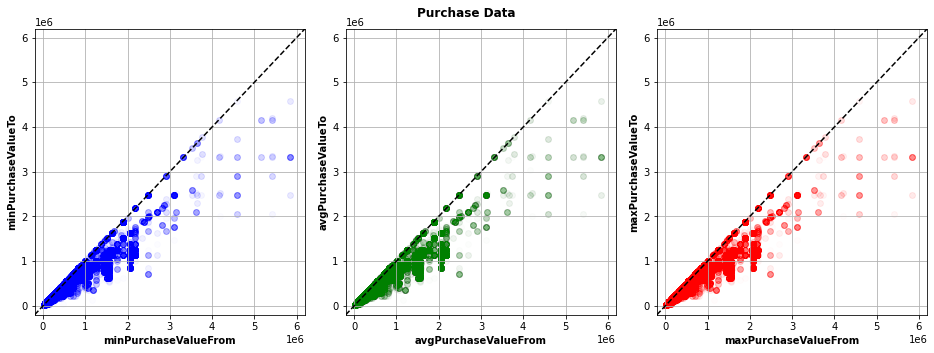

In [13]:
%%time

# Scatter plot of purchase values.
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
axes = axes.flatten()
axes[0].scatter(
    x=df_pp.minPurchaseValueFrom,
    y=df_pp.minPurchaseValueTo,
    color="blue",
    alpha=0.01,
    marker="o"
)
axes[1].scatter(
    x=df_pp.avgPurchaseValueFrom,
    y=df_pp.avgPurchaseValueTo,
    color="green",
    alpha=0.01,
    marker="o"
)
axes[2].scatter(
    x=df_pp.maxPurchaseValueFrom,
    y=df_pp.maxPurchaseValueTo,
    color="red",
    alpha=0.01,
    marker="o"
)

# Adjustments.
axes[0].set_xlabel("minPurchaseValueFrom", weight="bold")
axes[0].set_ylabel("minPurchaseValueTo", weight="bold")
axes[1].set_xlabel("avgPurchaseValueFrom", weight="bold")
axes[1].set_ylabel("avgPurchaseValueTo", weight="bold")
axes[2].set_xlabel("maxPurchaseValueFrom", weight="bold")
axes[2].set_ylabel("maxPurchaseValueTo", weight="bold")
plt.suptitle("Purchase Data", weight="bold")
plt.subplots_adjust(wspace=0.15, top=0.92)
for axis in axes:
    axis.set_ylim((-0.2e6, 6.2e6))
    axis.set_xlim((-0.2e6, 6.2e6))
    axis.grid()
    axis.plot(axis.get_xlim(), axis.get_xlim(), "--k")

if save_fig:
    plt.savefig(
        FIG_FOLDER + "challenge1.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )      

**From this figure, we can see that prices labeled with 'From' are equal or greater than values labeled with 'To'.**

**Lets see what happens when these two labels 'From' and 'To' are equal.**

In [14]:
# Show purchase data when min values are equal.
mask = df_pp.minPurchaseValueFrom == df_pp.minPurchaseValueTo
df_pp[mask][[col for col in df_pp.columns if "Purchase" in col] + ["amount"]]

,minPurchaseValueFrom,maxPurchaseValueFrom,avgPurchaseValueFrom,stddevPurchaseValueFrom,minPurchaseValueTo,maxPurchaseValueTo,avgPurchaseValueTo,stddevPurchaseValueTo,amount
creationDate,,,,,,,,,
2012-10-23,67200.0,67200.0,67200.0,NaN,67200.0,67200.0,67200.0,NaN,1.0
2012-10-24,67200.0,67200.0,67200.0,NaN,67200.0,67200.0,67200.0,NaN,1.0
2012-10-25,67200.0,67200.0,67200.0,0.0,67200.0,67200.0,67200.0,0.0,2.0
2012-10-26,67200.0,67200.0,67200.0,NaN,67200.0,67200.0,67200.0,NaN,1.0
2012-10-27,67200.0,67200.0,67200.0,0.0,67200.0,67200.0,67200.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...
2020-04-16,209580.0,209580.0,209580.0,NaN,209580.0,209580.0,209580.0,NaN,10.0
2020-04-16,1129800.0,1129800.0,1129800.0,NaN,1129800.0,1129800.0,1129800.0,NaN,1.0
2020-04-16,96180.0,96180.0,96180.0,0.0,96180.0,96180.0,96180.0,0.0,10.0


In [15]:
# Summary statistics.
df_pp[mask][[col for col in df_pp.columns if "Purchase" in col] + ["amount"]].describe()

,minPurchaseValueFrom,maxPurchaseValueFrom,avgPurchaseValueFrom,stddevPurchaseValueFrom,minPurchaseValueTo,maxPurchaseValueTo,avgPurchaseValueTo,stddevPurchaseValueTo,amount
count,1.432000e+04,1.432000e+04,1.432000e+04,5149.000000,1.432000e+04,1.432000e+04,1.432000e+04,5149.000000,14320.000000
mean,5.292373e+05,5.292675e+05,5.292512e+05,51.140535,5.292373e+05,5.292616e+05,5.292488e+05,41.311461,2.941131
std,6.042572e+05,6.042538e+05,6.042555e+05,2003.824531,6.042572e+05,6.042572e+05,6.042569e+05,1948.055982,4.153469
min,2.058000e+04,2.058000e+04,2.058000e+04,0.000000,2.058000e+04,2.058000e+04,2.058000e+04,0.000000,1.000000
25%,1.255800e+05,1.255800e+05,1.255800e+05,0.000000,1.255800e+05,1.255800e+05,1.255800e+05,0.000000,1.000000
50%,3.355800e+05,3.355800e+05,3.355800e+05,0.000000,3.355800e+05,3.355800e+05,3.355800e+05,0.000000,2.000000
75%,7.135800e+05,7.135800e+05,7.135800e+05,0.000000,7.135800e+05,7.135800e+05,7.135800e+05,0.000000,3.000000
max,4.578000e+06,4.578000e+06,4.578000e+06,118793.939239,4.578000e+06,4.578000e+06,4.578000e+06,118793.939239,93.000000


**From the table above, we can estimate that each instance of the original data table refers to the most expensive sku on that ordering. When 'From' and 'To' purchase features are equal, and then all 'min', 'max', and 'avg' prices are equal too, and this means that there was only one type of sku in the ordering, which could be a single or multiple units of that sku.**

**There is on invalid case to this rule. Let's drop it.**

In [16]:
# Invalid instance.
invalid = (df_pp.minPurchaseValueTo > df_pp.minPurchaseValueFrom)
df_pp[invalid]

,sku,size,color,skuCollection,skuUnitOfMeasurement,productSegment,productCategory,productLine,productCollection,productProfile,...,skuProducedInternationally,minPurchaseValueFrom,maxPurchaseValueFrom,avgPurchaseValueFrom,stddevPurchaseValueFrom,minPurchaseValueTo,maxPurchaseValueTo,avgPurchaseValueTo,stddevPurchaseValueTo,amount
creationDate,,,,,,,,,,,,,,,,,,,,,
2019-04-01,352,33,0,12,2,2,22,-1,21,29,...,True,217560.0,217560.0,217560.0,NaN,369180.0,369180.0,369180.0,NaN,1.0


In [17]:
# Drop it.
df_pp = df_pp[~invalid]

**Let's calculate the revenue (_faturamento_) based 'avgPurchaseValueTo' and 'amount' features.**

In [18]:
# Average revenue.
df_pp["avgRevenueTo"] = df_pp["avgPurchaseValueTo"] * df_pp["amount"]

**Question: What are the macro categories responsible for 80% of the billing over the entire dataset period?**

**Answer: 4 categories are responsible for 80% of the billing: C22, C9, C7, and C1 (see 'df_tmp' below).** 

In [19]:
# Total revenue in the whole period.
total_revenue = df_pp.avgRevenueTo.sum()

# Group data by macro category and then sum the revenue data ('tmp' means temporary).
s_tmp = df_pp.groupby(by="productMacroCategory")["avgRevenueTo"].sum()

# Sum and percentage by macro.
df_tmp = pd.concat(
    objs=[s_tmp, (s_tmp / total_revenue) * 100], 
    axis="columns",
    keys=["Sum", "Percentage"]
)

# Descending sum values.
df_tmp = df_tmp.sort_values(by="Sum", axis="index", ascending=False)

# Add column with cumulative percentage.
df_tmp["CumPercentage"] = df_tmp.Percentage.cumsum()

# Show results.
df_tmp

,Sum,Percentage,CumPercentage
productMacroCategory,,,
22,4.246084e+10,39.698134,39.698134
9,2.392672e+10,22.369931,62.068065
7,1.181423e+10,11.045541,73.113606
1,7.894540e+09,7.380882,80.494489
4,5.490529e+09,5.133288,85.627777
17,2.904474e+09,2.715495,88.343272
23,2.311111e+09,2.160739,90.504011
2,2.209619e+09,2.065850,92.569861
8,1.891806e+09,1.768716,94.338577


**Create simpler data set with the main macro category C22 from 2018 until the end of January 2020.**

In [20]:
# Only the main macro category.
mask = df_pp.productMacroCategory == int(22)

# Time selection.
df_pp = df_pp[mask].loc["2018": "2020-01"]

# Show it.
df_pp

,sku,size,color,skuCollection,skuUnitOfMeasurement,productSegment,productCategory,productLine,productCollection,productProfile,...,minPurchaseValueFrom,maxPurchaseValueFrom,avgPurchaseValueFrom,stddevPurchaseValueFrom,minPurchaseValueTo,maxPurchaseValueTo,avgPurchaseValueTo,stddevPurchaseValueTo,amount,avgRevenueTo
creationDate,,,,,,,,,,,,,,,,,,,,,
2018-01-01,254,33,57,16,2,2,22,5,13,6,...,461580.0,461580.0,461580.0,NaN,335580.0,335580.0,335580.0,NaN,2.0,671160.0
2018-01-01,126,24,57,9,0,2,13,59,17,19,...,929880.0,929880.0,929880.0,NaN,753480.0,753480.0,753480.0,NaN,2.0,1506960.0
2018-01-01,50,13,28,24,0,2,22,6,8,27,...,2063880.0,2063880.0,2063880.0,NaN,1131480.0,1131480.0,1131480.0,NaN,1.0,1131480.0
2018-01-01,87,33,57,9,2,2,22,9,16,0,...,503580.0,503580.0,503580.0,NaN,461580.0,461580.0,461580.0,NaN,1.0,461580.0
2018-01-01,10,19,52,21,0,2,22,59,3,19,...,1055880.0,1055880.0,1055880.0,NaN,829080.0,829080.0,829080.0,NaN,1.0,829080.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31,310,23,53,22,2,2,22,-1,16,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2020-01-31,380,13,57,9,0,2,13,59,17,19,...,751800.0,751800.0,751800.0,0.0,751800.0,751800.0,751800.0,0.0,5.0,3759000.0
2020-01-31,0,24,68,14,2,2,22,17,-1,0,...,1091580.0,1091580.0,1091580.0,0.0,671580.0,671580.0,671580.0,0.0,4.0,2686320.0


**Data split: train from 2018 to the end of 2019, and test beginning in January 2020.**

In [21]:
# Split with time blocking.
df_pp_train = df_pp.loc["2018": "2019"]
df_pp_test = df_pp.loc["2020-01"]

print(">>> Split proportions:")
print(f"* Train: {df_pp_train.shape[0] / df_pp.shape[0] * 100:>10.2f} %")
print(f"* Test: {df_pp_test.shape[0] / df_pp.shape[0] * 100:>11.2f} %")

>>> Split proportions:
* Train:      95.86 %
* Test:        4.14 %


In [22]:
# Show it.
df_pp_train

,sku,size,color,skuCollection,skuUnitOfMeasurement,productSegment,productCategory,productLine,productCollection,productProfile,...,minPurchaseValueFrom,maxPurchaseValueFrom,avgPurchaseValueFrom,stddevPurchaseValueFrom,minPurchaseValueTo,maxPurchaseValueTo,avgPurchaseValueTo,stddevPurchaseValueTo,amount,avgRevenueTo
creationDate,,,,,,,,,,,,,,,,,,,,,
2018-01-01,254,33,57,16,2,2,22,5,13,6,...,461580.0,461580.0,461580.0,NaN,335580.0,335580.0,335580.0,NaN,2.0,671160.0
2018-01-01,126,24,57,9,0,2,13,59,17,19,...,929880.0,929880.0,929880.0,NaN,753480.0,753480.0,753480.0,NaN,2.0,1506960.0
2018-01-01,50,13,28,24,0,2,22,6,8,27,...,2063880.0,2063880.0,2063880.0,NaN,1131480.0,1131480.0,1131480.0,NaN,1.0,1131480.0
2018-01-01,87,33,57,9,2,2,22,9,16,0,...,503580.0,503580.0,503580.0,NaN,461580.0,461580.0,461580.0,NaN,1.0,461580.0
2018-01-01,10,19,52,21,0,2,22,59,3,19,...,1055880.0,1055880.0,1055880.0,NaN,829080.0,829080.0,829080.0,NaN,1.0,829080.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31,148,23,28,23,2,2,22,-1,22,31,...,369180.0,369180.0,369180.0,0.0,234780.0,234780.0,234780.0,0.0,9.0,2113020.0
2019-12-31,41,13,68,14,2,2,22,17,-1,0,...,965580.0,965580.0,965580.0,0.0,587580.0,587580.0,587580.0,0.0,5.0,2937900.0
2019-12-31,117,39,44,12,2,2,22,67,21,15,...,419580.0,419580.0,419580.0,NaN,419580.0,419580.0,419580.0,NaN,2.0,839160.0


In [23]:
# Show it.
df_pp_test

,sku,size,color,skuCollection,skuUnitOfMeasurement,productSegment,productCategory,productLine,productCollection,productProfile,...,minPurchaseValueFrom,maxPurchaseValueFrom,avgPurchaseValueFrom,stddevPurchaseValueFrom,minPurchaseValueTo,maxPurchaseValueTo,avgPurchaseValueTo,stddevPurchaseValueTo,amount,avgRevenueTo
creationDate,,,,,,,,,,,,,,,,,,,,,
2020-01-01,198,23,53,22,2,2,22,5,16,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2020-01-01,52,23,68,12,2,2,22,-1,21,10,...,587580.0,587580.0,587580.0,NaN,461580.0,461580.0,461580.0,NaN,1.0,461580.0
2020-01-01,415,13,53,11,2,2,22,56,24,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2020-01-01,380,13,57,9,0,2,13,59,17,19,...,751800.0,751800.0,751800.0,NaN,751800.0,751800.0,751800.0,NaN,1.0,751800.0
2020-01-01,362,23,44,22,2,2,22,5,16,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31,310,23,53,22,2,2,22,-1,16,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2020-01-31,380,13,57,9,0,2,13,59,17,19,...,751800.0,751800.0,751800.0,0.0,751800.0,751800.0,751800.0,0.0,5.0,3759000.0
2020-01-31,0,24,68,14,2,2,22,17,-1,0,...,1091580.0,1091580.0,1091580.0,0.0,671580.0,671580.0,671580.0,0.0,4.0,2686320.0


## Part 2 - Univariate Time Series Forecasting

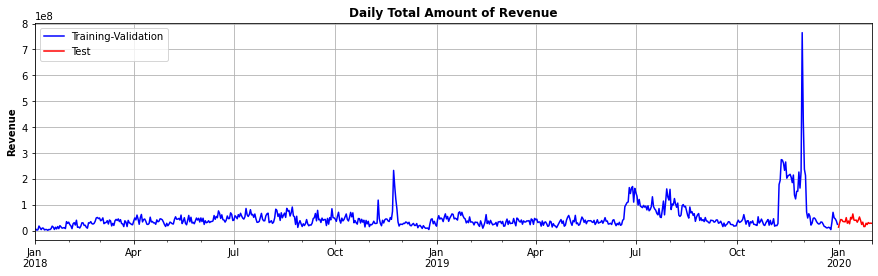

In [24]:
# Total daily revenue.
ts = df_pp.avgRevenueTo.resample("1D").sum()
ts_train = df_pp_train.avgRevenueTo.resample("1D").sum()
ts_test = df_pp_test.avgRevenueTo.resample("1D").sum()

# Make figure for these time series.
plt.figure(figsize=(15, 4))
ts_train.plot(color="blue", label="Training-Validation")
ts_test.plot(color="red", label="Test")
plt.xlabel("")
plt.ylabel("Revenue", weight="bold")
plt.title("Daily Total Amount of Revenue", weight="bold")
plt.legend()
plt.grid()

if save_fig:
    plt.savefig(
        FIG_FOLDER + "challenge2.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )   

**Search for hyperparameters**

In [25]:
# Dimension of the autoregressive process.
window_size = 30

# Last number of days in train time series to be used as validation.
validation_size = 30

# Train and validation.
X_train_validation, y_train_validation = univariate_auto_features(
    time_series=ts_train.values, 
    window_size=window_size
)

# Whole time series.
X, y = univariate_auto_features(
    time_series=ts.values, 
    window_size=window_size
)

# Predifined constant split.
validation_fold = (-1) * np.ones(X_train_validation.shape[0])
validation_fold[-validation_size:] = 0
ps = PredefinedSplit(validation_fold)

# Metrics for evaluating models. RMSE is used for hyper parameter search in cross validation.
scoring = {
    "neg_rmse": make_scorer(mean_squared_error, squared=False, greater_is_better=False),
    "neg_mse": make_scorer(mean_squared_error, squared=True, greater_is_better=False),
    "neg_mae": make_scorer(mean_absolute_error, greater_is_better=False),
    "r2": make_scorer(r2_score, greater_is_better=True),
    "mape": make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    "wmape": make_scorer(weighted_mean_absolute_percentage_error, greater_is_better=False)
}

# Append model to preprocessing pipeline. Now we have a full prediction pipeline.
model = Pipeline(steps=[
        ("model", XGBRegressor())
])

# Exhaustive search for the best model.
search = GridSearchCV(
    estimator=model,
    param_grid={
        "model__n_estimators": [10, 20, 40, 50, 60, 100, 200],
        "model__max_depth":[2, 3, 4, 5, 6],
        "model__learning_rate": [0.08, 0.10, 0.20],
        "model__reg_alpha": [0.1, 1, 10, 20, 40],
        "model__reg_lambda": [0.1, 1, 10, 20, 40]
    },
    scoring=scoring,
    n_jobs=-1,
    cv=ps,
    verbose=1,
    return_train_score=True,
    refit="wmape"
)

# Run fit with all sets of parameters.
_ = search.fit(X_train_validation, y_train_validation)

Fitting 1 folds for each of 2625 candidates, totalling 2625 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 1170 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 2370 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 2625 out of 2625 | elapsed:   32.3s finished


In [26]:
# Do not show all results.
df_tmp = pd.DataFrame(search.cv_results_)
cols = [col for col in df_tmp.columns \
        if ("mean" not in col) and ("std" not in col) and ("rank" not in col)]
df_tmp = df_tmp[cols]

# Now we have the following results.
print("\n>>> Results for best hyper parameters:")
print(df_tmp.iloc[search.best_index_])

# Optimum hyper parameter set.
print("\n>>> Best hyper parameters:")
print("*", search.best_params_)

# Use this model.
model = search.best_estimator_


>>> Results for best hyper parameters:
param_model__learning_rate                                                  0.2
param_model__max_depth                                                        3
param_model__n_estimators                                                    10
param_model__reg_alpha                                                      0.1
param_model__reg_lambda                                                      10
params                        {'model__learning_rate': 0.2, 'model__max_dept...
split0_test_neg_rmse                                                -1.8252e+07
split0_train_neg_rmse                                              -2.97968e+07
split0_test_neg_mse                                                -3.33135e+14
split0_train_neg_mse                                                -8.8785e+14
split0_test_neg_mae                                                -1.19819e+07
split0_train_neg_mae                                               -1.26016e+07


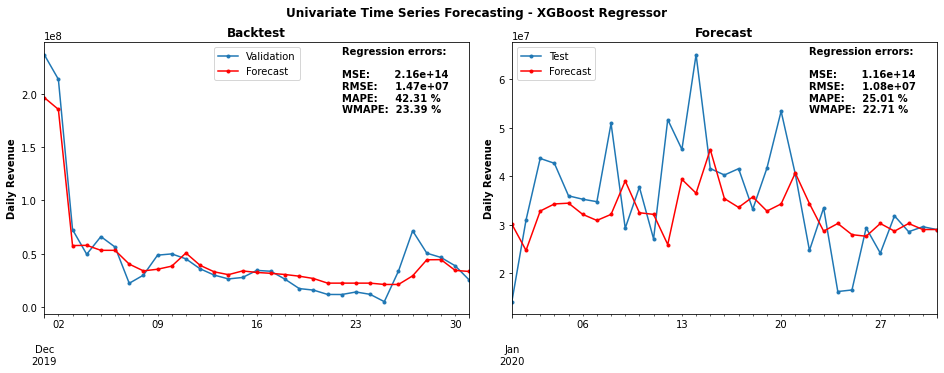

In [27]:
# Forecast on the whole time series, train and test.
ts_pred = pd.Series(data=model.predict(X), index=ts.index[window_size:])

# Calculate metrics of backtest.
mse_bt = mean_squared_error(ts["2019-12"], ts_pred["2019-12"])
rmse_bt = mean_squared_error(ts["2019-12"], ts_pred["2019-12"], squared=False)
mape_bt = mean_absolute_percentage_error(ts["2019-12"], ts_pred["2019-12"])
wmape_bt = weighted_mean_absolute_percentage_error(ts["2019-12"], ts_pred["2019-12"])

# Text with results for regression metrics of back test.
text_bt = \
"""
Regression errors:  

MSE:       %.2e 
RMSE:     %.2e 
MAPE:     %.2f %%
WMAPE:  %.2f %%       
""" %(mse_bt, rmse_bt, mape_bt, wmape_bt)

# Forecasts metrics.
mse_fc = mean_squared_error(ts["2020-01"], ts_pred["2020-01"])
rmse_fc = mean_squared_error(ts["2020-01"], ts_pred["2020-01"], squared=False)
mape_fc = mean_absolute_percentage_error(ts["2020-01"], ts_pred["2020-01"])
wmape_fc = weighted_mean_absolute_percentage_error(ts["2020-01"], ts_pred["2020-01"])

# Text with results for regression metrics of the forecasts.
text_fc = \
"""
Regression errors:  

MSE:       %.2e 
RMSE:     %.2e
MAPE:     %.2f %% 
WMAPE:  %.2f %%       
""" %(mse_fc, rmse_fc, mape_fc, wmape_fc)

# Plot results.
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=False)
ts["2019-12"].plot(ax=axes[0], marker=".", label="Validation")
ts_pred["2019-12"].plot(ax=axes[0], marker=".", color="red", label="Forecast")
ts["2020-01"].plot(ax=axes[1], marker=".", label="Test")
ts_pred["2020-01"].plot(ax=axes[1], marker=".", color="red", label="Forecast")

# Adjustments.
axes[0].legend(loc="upper center")
axes[1].legend(loc="upper left")
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[0].set_ylabel("Daily Revenue", weight="bold")
axes[1].set_ylabel("Daily Revenue", weight="bold")
axes[0].set_title("Backtest", weight="bold")
axes[1].set_title("Forecast", weight="bold")
fig.suptitle("Univariate Time Series Forecasting - XGBoost Regressor", weight="bold")
plt.subplots_adjust(wspace=0.10)
axes[0].axes.text(x=0.70, y=0.70, s=text_bt, weight="bold", transform=axes[0].transAxes)
axes[1].axes.text(x=0.70, y=0.70, s=text_fc, weight="bold", transform=axes[1].transAxes)

if save_fig:
    plt.savefig(
        FIG_FOLDER + "challenge3.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )   

**Part 3: Multivariate Time Series Forecasting**

## Part 3 - Multivariate Time Series Forecasting

In [28]:
# Target.
df_y = df_pp.resample("1D").sum()["avgRevenueTo"]

# Make a new data matrix with more features to be used in Multivariate forecasting.
df_X  = df_pp.resample("1D").agg(func={
    "avgRevenueTo": [lambda x: x.size, np.min],
    "minPurchaseValueFrom": [np.sum, np.max],
    "skuLength": [np.mean],
    "skuWidth": [np.mean],
    "skuHeight": [np.mean],
    "amount": [np.max]
})

# Rename columns.
df_X.columns = df_X.columns.to_flat_index()
df_X.columns = [
    "avgRevenueToDailyCount", 
    "avgRevenueToDailyMin",
    "minPurchaseValueFromDailySum",
    "minPurchaseValueFromDailyMax",
    "skuLengthDailyMean", 
    "skuWidthDailyMean",
    "skuHeightDailyMean",
    "amountDailyMax"
]

# New features.
df_X

,avgRevenueToDailyCount,avgRevenueToDailyMin,minPurchaseValueFromDailySum,minPurchaseValueFromDailyMax,skuLengthDailyMean,skuWidthDailyMean,skuHeightDailyMean,amountDailyMax
creationDate,,,,,,,,
2018-01-01,7.0,461580.0,5896380.0,2063880.0,33.142857,6.642857,31.357143,2.0
2018-01-02,4.0,461580.0,4204620.0,2063880.0,36.500000,11.125000,36.625000,4.0
2018-01-03,5.0,677880.0,4110540.0,2063880.0,33.400000,6.900000,31.200000,1.0
2018-01-04,6.0,677880.0,3942540.0,2063880.0,31.166667,7.083333,33.083333,2.0
2018-01-05,6.0,713580.0,6341580.0,2063880.0,31.166667,7.500000,33.083333,8.0
...,...,...,...,...,...,...,...,...
2020-01-27,21.0,335580.0,7735140.0,1133580.0,30.142857,7.247619,28.785714,15.0
2020-01-28,27.0,377580.0,12182100.0,2898000.0,31.259259,6.951852,28.537037,17.0
2020-01-29,24.0,230580.0,10292520.0,1507800.0,31.791667,7.072917,28.729167,29.0


In [29]:
# Dimension of the autoregressive process.
window_size = 30

# Last number of days in train time series to be used as validation.
validation_size = 30

# Whole time series.
X, y = make_sequences(
    features=df_X.values, 
    target=df_y.values,
    window_size=window_size
)

# Train and validation.
X_train_validation, y_train_validation = make_sequences(
    features=df_X.loc[ts_train.index].values, 
    target=df_y.loc[ts_train.index].values,
    window_size=window_size
)

# Predifined constant split.
validation_fold = (-1) * np.ones(X_train_validation.shape[0])
validation_fold[-validation_size:] = 0
ps = PredefinedSplit(validation_fold)

# Metrics for evaluating models. RMSE is used for hyper parameter search in cross validation.
scoring = {
    "neg_rmse": make_scorer(mean_squared_error, squared=False, greater_is_better=False),
    "neg_mse": make_scorer(mean_squared_error, squared=True, greater_is_better=False),
    "neg_mae": make_scorer(mean_absolute_error, greater_is_better=False),
    "r2": make_scorer(r2_score, greater_is_better=True),
    "mape": make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    "wmape": make_scorer(weighted_mean_absolute_percentage_error, greater_is_better=False)
}

# Append model to preprocessing pipeline. Now we have a full prediction pipeline.
model = Pipeline(steps=[
        ("pca", PCA()),
        ("model", XGBRegressor())
])

# Exhaustive search for the best model.
search = GridSearchCV(
    estimator=model,
    param_grid={
        "pca__n_components": [2, 5],
        "model__n_estimators": [50, 100, 200],
        "model__max_depth":[4, 5],
        "model__learning_rate": [0.01, 0.05, 0.1],
        "model__reg_alpha": [10, 20, 40],
        "model__reg_lambda": [10, 20, 40]
    },
    scoring=scoring,
    n_jobs=-1,
    cv=ps,
    verbose=1,
    return_train_score=True,
    refit="wmape"
)

# Run fit with all sets of parameters.
_ = search.fit(X_train_validation, y_train_validation)

Fitting 1 folds for each of 324 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:    2.4s finished


In [30]:
# Do not show all results.
df_tmp = pd.DataFrame(search.cv_results_)
cols = [col for col in df_tmp.columns \
        if ("mean" not in col) and ("std" not in col) and ("rank" not in col)]
df_tmp = df_tmp[cols]

# Now we have the following results.
print("\n>>> Results for best hyper parameters:")
print(df_tmp.iloc[search.best_index_])

# Optimum hyper parameter set.
print("\n>>> Best hyper parameters:")
print("*", search.best_params_)

# Use this model.
model = search.best_estimator_


>>> Results for best hyper parameters:
param_model__learning_rate                                                  0.1
param_model__max_depth                                                        5
param_model__n_estimators                                                   200
param_model__reg_alpha                                                       10
param_model__reg_lambda                                                      40
param_pca__n_components                                                       5
params                        {'model__learning_rate': 0.1, 'model__max_dept...
split0_test_neg_rmse                                               -2.22498e+07
split0_train_neg_rmse                                              -2.19863e+07
split0_test_neg_mse                                                -4.95055e+14
split0_train_neg_mse                                               -4.83396e+14
split0_test_neg_mae                                                -1.46197e+07


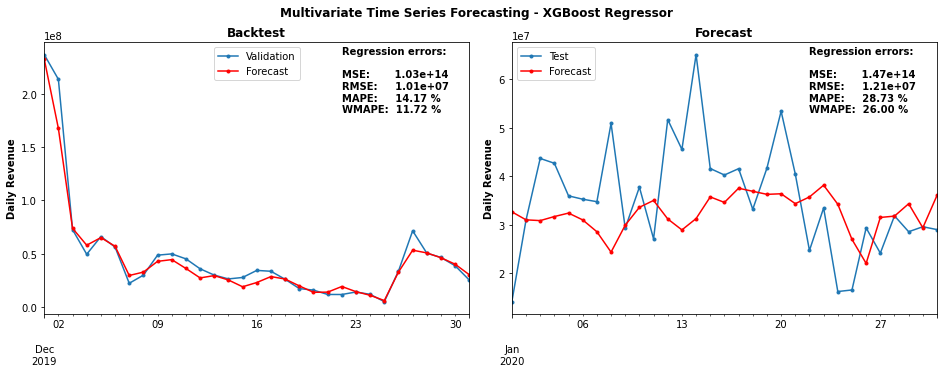

In [31]:
# Forecast on the whole time series, train and test.
ts_pred = pd.Series(data=model.predict(X), index=ts.index[window_size:])

# Calculate metrics of backtest.
mse_bt = mean_squared_error(ts["2019-12"], ts_pred["2019-12"])
rmse_bt = mean_squared_error(ts["2019-12"], ts_pred["2019-12"], squared=False)
mape_bt = mean_absolute_percentage_error(ts["2019-12"], ts_pred["2019-12"])
wmape_bt = weighted_mean_absolute_percentage_error(ts["2019-12"], ts_pred["2019-12"])

# Text with results for regression metrics of back test.
text_bt = \
"""
Regression errors:  

MSE:       %.2e 
RMSE:     %.2e 
MAPE:     %.2f %%
WMAPE:  %.2f %%       
""" %(mse_bt, rmse_bt, mape_bt, wmape_bt)

# Forecasts metrics.
mse_fc = mean_squared_error(ts["2020-01"], ts_pred["2020-01"])
rmse_fc = mean_squared_error(ts["2020-01"], ts_pred["2020-01"], squared=False)
mape_fc = mean_absolute_percentage_error(ts["2020-01"], ts_pred["2020-01"])
wmape_fc = weighted_mean_absolute_percentage_error(ts["2020-01"], ts_pred["2020-01"])

# Text with results for regression metrics of the forecasts.
text_fc = \
"""
Regression errors:  

MSE:       %.2e 
RMSE:     %.2e
MAPE:     %.2f %%
WMAPE:  %.2f %%       
""" %(mse_fc, rmse_fc, mape_fc, wmape_fc)

# Plot results.
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=False)
ts["2019-12"].plot(ax=axes[0], marker=".", label="Validation")
ts_pred["2019-12"].plot(ax=axes[0], marker=".", color="red", label="Forecast")
ts["2020-01"].plot(ax=axes[1], marker=".", label="Test")
ts_pred["2020-01"].plot(ax=axes[1], marker=".", color="red", label="Forecast")

# Adjustments.
axes[0].legend(loc="upper center")
axes[1].legend(loc="upper left")
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[0].set_ylabel("Daily Revenue", weight="bold")
axes[1].set_ylabel("Daily Revenue", weight="bold")
axes[0].set_title("Backtest", weight="bold")
axes[1].set_title("Forecast", weight="bold")
fig.suptitle("Multivariate Time Series Forecasting - XGBoost Regressor", weight="bold")
plt.subplots_adjust(wspace=0.10)
axes[0].axes.text(x=0.70, y=0.70, s=text_bt, weight="bold", transform=axes[0].transAxes)
axes[1].axes.text(x=0.70, y=0.70, s=text_fc, weight="bold", transform=axes[1].transAxes)

if save_fig:
    plt.savefig(
        FIG_FOLDER + "challenge4.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )   